In [1]:
'''
Prediction 1:
scenario_1: The word test appears in at least in one field
scenario_2: All fields are at most the same
scenario_3: One word field
scenario_4: Random characters in at least in one field
'''
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import words
import random
import matplotlib
import matplotlib.pyplot as plt
nltk.download('words')

[nltk_data] Downloading package words to
[nltk_data]     /Users/darrylbalderas/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# import spam collection messages
column_names = ['label', 'title']
message_data = pd.read_table("SMSSpamCollection", names=column_names)

In [3]:
# Remove rows that contain spam label and reset indexes
message_data = message_data.drop(message_data[message_data.label == "spam"].index).reset_index(drop=True)

In [4]:
# Drop label column
message_data = message_data.drop('label', axis=1)

In [5]:
message_data.head(10)

,title
0,"Go until jurong point, crazy.. Available only ..."
1,Ok lar... Joking wif u oni...
2,U dun say so early hor... U c already then say...
3,"Nah I don't think he goes to usf, he lives aro..."
4,Even my brother is not like to speak with me. ...
5,As per your request 'Melle Melle (Oru Minnamin...
6,I'm gonna be home soon and i don't want to tal...
7,I've been searching for the right words to tha...
8,I HAVE A DATE ON SUNDAY WITH WILL!!
9,Oh k...i'm watching here:)


In [6]:
english_words = dict.fromkeys(words.words(), None)

In [7]:
def is_word(word):
    try:
        x = english_words[word]
        return True
    except:
        return False


def get_false_word_indexes(data, percentage):
    indexes = []
    for index, message in enumerate(data['title']):
        false_word_count = 0
        for word in message.split():
            if not is_word(word):
                false_word_count += 1
                if false_word_count/len(message) > false_word_percentage:
                    indexes.append(index)
                    break
    return indexes

def remove_single_words(data):
    indexes = []
    for index, message in enumerate(data['title']):
        if len(message.split()) > 1:
            continue
        indexes.append(index)
    return indexes
    

In [8]:
%%time
false_word_percentage = 0.02
indexes = get_false_word_indexes(message_data, false_word_percentage)
print('{} number of indexes will be deleted'.format(len(indexes)))

4741 number of indexes will be deleted
CPU times: user 18.7 ms, sys: 877 µs, total: 19.6 ms
Wall time: 19.2 ms


In [9]:
%%time
original_size = message_data.shape[0]
real_messages = message_data.drop(message_data.index[indexes]).reset_index(drop=True)
print('Data size went from {} to {}'.format(original_size, real_messages.shape[0]))

Data size went from 4825 to 84
CPU times: user 3.08 ms, sys: 999 µs, total: 4.08 ms
Wall time: 3.12 ms


In [10]:
real_messages.head()

,title
0,I see the letter B on my car
1,Ok i am on the way to home hi hi
2,I see a cup of coffee animation
3,Keep yourself safe for me because I need you a...
4,Or ill be a little closer like at the bus stop...


In [11]:
%%time
indexes = remove_single_words(real_messages)
print('{} number of indexes will be deleted'.format(len(indexes)))
no_single_messages = real_messages.drop(real_messages.index[indexes]).reset_index(drop=True)
print('Data size went from {} to {}'.format(real_messages.shape[0], no_single_messages.shape[0]))

8 number of indexes will be deleted
Data size went from 84 to 76
CPU times: user 1.91 ms, sys: 366 µs, total: 2.28 ms
Wall time: 2.03 ms


In [12]:
def add_test_message(sentence):
    words = sentence.split()
    choice = random.randint(0,len(words))
    update_sentence = " ".join(words[:choice]) + " test " + " ".join(words[choice:])
    return update_sentence.strip()

In [13]:
# Show that the test message in a random index of the sentence
add_test_message("Hello my name")

'Hello my test name'

In [14]:
def shuffle_dataframe(df, num_shuffles):
    for x in range(num_shuffles):
        for column in df.columns:
            df[column] = df[column].sample(frac=1).reset_index(drop=True)
    return df

In [15]:
def create_default_scenario(df):
    scenario = pd.DataFrame(df)
    scenario['subtitle'] = scenario['title']
    scenario['message'] = scenario['title']
    return scenario

In [16]:
def create_scenario_one(messages):
    df = create_default_scenario(messages)
    df = shuffle_dataframe(df, num_shuffles=30)
    for index in df.index:
        prob = random.random()
        choice = random.choice(df.columns)
        if prob < 0.33:
            df.loc[index][choice] = add_test_message(df.loc[index][choice])
        elif prob < 0.66:
            columns = list(df.columns)
            df.loc[index][choice] = add_test_message(df.loc[index][choice])
            columns.remove(choice)
            choice = random.choice(columns)
            df.loc[index][choice] = add_test_message(df.loc[index][choice])
        else:
            for column in df.columns:
                df.loc[index][column] = add_test_message(df.loc[index][column])
        return df

In [17]:
def create_scenario_two(messages):
    return create_default_scenario(messages)

In [18]:
def create_scenario_three(messages):
    df = create_default_scenario(messages)
    for column in df.columns:
        df[column] = df[column].apply(lambda x: x.split()[0])
    return df

In [19]:
import string
def create_random_chars():
    letters = string.ascii_letters
    num_chars = random.randint(5, 30)
    return "".join([random.choice(string.ascii_letters) for _ in range(num_chars)])

def create_scenario_four(messages):
    df = create_default_scenario(messages)
    for column in df.columns:
        df[column] = df[column].apply(lambda x: create_random_chars())
    return df

In [20]:
create_scenario_one(no_single_messages).head()

,title,subtitle,message
0,U should test have made an appointment,Ok leave no need to ask,Which is weird because test I know I had it at...
1,Keep yourself safe for me because I need you a...,did u get that message,Sitting in mu waiting for everyone to get out ...
2,No da if you run that it activate the full ver...,No da if you run that it activate the full ver...,I didnt get anything da
3,I have a rather prominent bite mark on my righ...,I will come tomorrow di,Btw regarding that we should really try to see...
4,No need to say anything to me. I know i am an ...,Ok ill tell the company,Ok i am on the way to railway


In [21]:
create_scenario_two(no_single_messages).head()

,title,subtitle,message
0,U should have made an appointment,U should have made an appointment,U should have made an appointment
1,Keep yourself safe for me because I need you a...,Keep yourself safe for me because I need you a...,Keep yourself safe for me because I need you a...
2,No da if you run that it activate the full ver...,No da if you run that it activate the full ver...,No da if you run that it activate the full ver...
3,I have a rather prominent bite mark on my righ...,I have a rather prominent bite mark on my righ...,I have a rather prominent bite mark on my righ...
4,No need to say anything to me. I know i am an ...,No need to say anything to me. I know i am an ...,No need to say anything to me. I know i am an ...


In [22]:
create_scenario_three(no_single_messages).head()

,title,subtitle,message
0,U,U,U
1,Keep,Keep,Keep
2,No,No,No
3,I,I,I
4,No,No,No


In [23]:
create_scenario_four(no_single_messages).head()

,title,subtitle,message
0,XNoRaDFIZi,qWkqsOwgw,sKCYqqWFfpcOfpRCOdskkVFvrdHq
1,RDGZhMhmysxfUfnbzqAGPULY,QvhYEdZgmNHQhfrkHtwto,fjQNSwMYFRPCAQhFJ
2,iVHWamlVeDAaxQyY,XrCJNTAMueApkEfWMyAUuQoSNU,rISuKDDtfb
3,nRmoIjLRKf,nzMMSDqYlZ,ZnvwEOfCwqeLvtKwrL
4,BqryuSvgNcUFvilCUnyiYJDcRe,cWPwzaf,bQVaZLyObIA


In [24]:
# concatenate dataframes that has possible test messages
indexes = remove_single_words(real_messages)
no_single_messages = real_messages.drop(real_messages.index[indexes]).reset_index(drop=True)
test_messages = pd.concat([create_scenario_one(no_single_messages),
          create_scenario_two(no_single_messages),
          create_scenario_three(no_single_messages),
          create_scenario_four(no_single_messages)])

In [25]:
# add label column for distinguish that this is a test message 
test_messages['label'] = 1
test_messages.head()

,title,subtitle,message,label
0,The monthly amount is not that test terrible a...,"Damn, can you make test it tonight or do you w...",twenty past five he said test will this train ...,1
1,"Cool, want me to go to kappa or should I meet ...",Ok i am on the way to railway,K do I need a login or anything,1
2,I can take you at like noon,Please tell me you have some of that special s...,Sitting in mu waiting for everyone to get out ...,1
3,U should have made an appointment,I need to come home and give you some good lov...,The monthly amount is not that terrible and yo...,1
4,Keep yourself safe for me because I need you a...,I will see in half an hour,"Cool, want me to go to kappa or should I meet ...",1


In [26]:

indexes = remove_single_words(real_messages)
no_single_messages = real_messages.drop(real_messages.index[indexes]).reset_index(drop=True)
no_test_messages = create_default_scenario(no_single_messages)
no_test_messages = shuffle_dataframe(no_test_messages, num_shuffles=30)

In [27]:
no_test_messages['label'] = 0
no_test_messages.head()

,title,subtitle,message,label
0,No da if you run that it activate the full ver...,I think i am disturbing her da,I am on the way to ur home,0
1,"not that I know of, most people up here are st...",I love ya too but try and budget your money be...,Ok which your another number,0
2,I didnt get anything da,"Damn, can you make it tonight or do you want t...",I will come tomorrow di,0
3,Ok no prob,Ok ill tell the company,K do I need a login or anything,0
4,Would me smoking you out help us work through ...,I know a few people I can hit up and fuck to t...,We stopped to get ice cream and will go back a...,0


In [28]:
# concatenate dataframes test and not test messages
for x in range(30):
    df = pd.concat([test_messages, no_test_messages]).sample(frac=1).reset_index(drop=True)

In [29]:
df.head()

,title,subtitle,message,label
0,AVPLemtRoWhaDIMshwtMmNdWi,eXRGkISUSCqzpIEsAP,OeiZFidIWBaGE,1
1,FMktkPWwkmsPoqPGQQrqaItwZ,pTaCgBHeZOPoGAnRNExLYWZA,nyxEkdhi,1
2,pubLanyMpaPXRkYkpL,pNIGiToItqmpzcy,tGzmTKHvCsEXnDsdDNI,1
3,pubLanyMpaPXRkYkpL,pNIGiToItqmpzcy,tGzmTKHvCsEXnDsdDNI,1
4,EhMYMfuMsVcWM,bbzbeH,HIjRLMyDLUQQjLQsNVEUgd,1


In [30]:
df.groupby('label').describe()

message                                                                 \
        count unique                                                top freq   
label                                                                          
0          76     72  Ok then i will come to ur home after half an hour    2   
1         304    148                                        ibKtZCNfCXA    3   

      subtitle                                      title         \
         count unique                      top freq count unique   
label                                                              
0           76     72  I will come tomorrow di    2    76     72   
1          304    148   CNBulSanBlePlzxEochkNk    3   304    148   

                                        
                              top freq  
label                                   
0      I am on the way to ur home    2  
1                         QFdAHlQ    3

In [31]:
df['title_length'] = df['title'].apply(len)
df['subtitle_length'] = df['subtitle'].apply(len)
df['message_length'] = df['message'].apply(len)

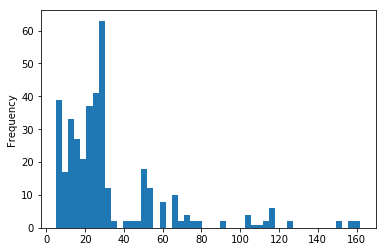

In [32]:
df['title_length'].plot(bins=50,kind='hist')

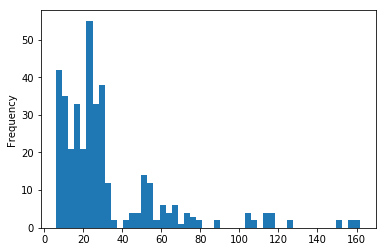

In [33]:
df['subtitle_length'].plot(bins=50,kind='hist')

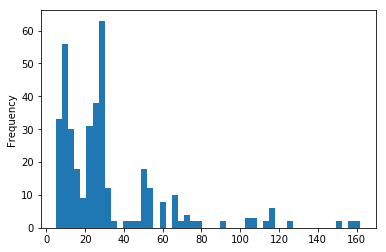

In [34]:
df['message_length'].plot(bins=50,kind='hist')